In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Country,year,dt,AverageTemperature,AverageTemperatureUncertainty,month,day,Entity,Year,cum_co2_em
0,Africa,1950,1950-06-16 12:00:00,23.880833,0.143667,6.5,1.0,Africa,1950,1.737904e+09
1,Africa,1951,1951-06-16 12:00:00,24.128333,0.212333,6.5,1.0,Africa,1951,1.839029e+09
2,Africa,1952,1952-06-16 08:00:00,24.275917,0.138167,6.5,1.0,Africa,1952,1.949354e+09
3,Africa,1953,1953-06-16 12:00:00,24.093583,0.129917,6.5,1.0,Africa,1953,2.061362e+09
4,Africa,1954,1954-06-16 12:00:00,23.942333,0.173417,6.5,1.0,Africa,1954,2.178898e+09


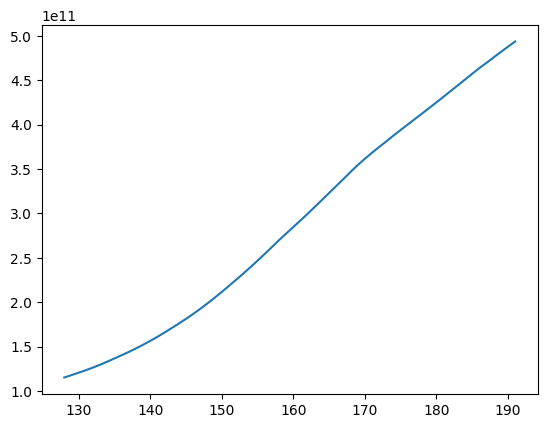

In [7]:
europe = df[df['Country'] == 'Europe']
plt.plot(europe["cum_co2_em"])
plt.show()

In [23]:
timeseries = europe['AverageTemperature']
timeseries.head()

128    8.487500
129    8.286500
130    7.926417
131    8.418167
132    7.730917
Name: AverageTemperature, dtype: float64

In [24]:
# train-test split for time series
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print(len(train), len(test))

51 13


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [26]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [27]:
lookback = 1
X_train, y_train = create_dataset(train.values, lookback=lookback)
X_test, y_test = create_dataset(test.values, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([50, 1]) torch.Size([50, 1])
torch.Size([12, 1]) torch.Size([12, 1])


/var/folders/ky/1wm4y72s6vv4yc8wyfnz3b9c0000gq/T/ipykernel_11325/778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [28]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [29]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

RuntimeError: mat1 and mat2 must have the same dtype